In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
import pickle

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



CPU times: total: 5.61 s
Wall time: 6.13 s


In [2]:
class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0604
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def extract_number_pth(filename):
    return int(filename.split('_')[-1].split('.')[0])

def extract_number_dir(filename):
    return int(filename.split('_')[-1])

def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def save_metrics(data, filename):
    """ 儲存數據到Pickle檔案 """
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

def load_metrics(filename):
    """ 從Pickle檔案讀取數據 """
    with open(filename, 'rb') as f:
        return pickle.load(f)

def test_model(model, test_loader, base_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # for 11 種不同比例的 distillation_loss
    all_avg_metrics = []
    all_std_metrics = []
    distillation_loss_dirs = sorted(os.listdir(base_dir), key=extract_number_dir)
    print("distillation_loss_dir = ", distillation_loss_dirs)
    for distillation_loss_dir in distillation_loss_dirs:
        print("[Evaluate on Test DataSet] Current distillation_loss is ", distillation_loss_dir)
        # for 總共18個 DataSet size
        avg_metrics = []
        std_metrics = []
        weight_dir_path = os.path.join(base_dir, distillation_loss_dir)
        weight_files = sorted(os.listdir(weight_dir_path), key=extract_number_pth)
        for weight_file in weight_files:
            print("[Evaluate each weight trained on different DataSet size] weight_file = ", weight_file)
            model.load_state_dict(torch.load(os.path.join(weight_dir_path, weight_file)))
            model.eval()

            total_loss = []
            iou_scores = []
            accuracies = []
            precisions = []
            recalls = []
            f1_scores = []

            with torch.no_grad():
                for idx, (image, mask) in enumerate(test_loader):
                    image, mask = image.to(device), mask.to(device)
                    outputs = model(image)
                    pred_mask = outputs['out'].argmax(dim=1)

                    # Compute loss
                    loss = criterion(outputs['out'], mask.squeeze(1).long())
                    total_loss.append(loss.item())

                    # Convert to binary format for evaluation
                    mask_np = mask.cpu().numpy().squeeze(1)
                    pred_mask_np = pred_mask.cpu().numpy()

                    # Flatten the arrays for comparison
                    true_flat = mask_np.flatten()
                    pred_flat = pred_mask_np.flatten()

                    # Calculate metrics
                    iou_scores.append(jaccard_score(true_flat, pred_flat, average='binary', zero_division=0))
                    accuracies.append(accuracy_score(true_flat, pred_flat))
                    precisions.append(precision_score(true_flat, pred_flat, average='binary', zero_division=0))
                    recalls.append(recall_score(true_flat, pred_flat, average='binary', zero_division=0))
                    f1_scores.append(f1_score(true_flat, pred_flat, average='binary', zero_division=0))

            avg_metric = {
                'loss': np.mean(total_loss),
                'iou': np.mean(iou_scores),
                'accuracy': np.mean(accuracies),    
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'f1': np.mean(f1_scores)
            }
            avg_metrics.append(avg_metric)

            std_metric = {
                'loss': np.std(total_loss),
                'iou': np.std(iou_scores),
                'accuracy': np.std(accuracies),    
                'precision': np.std(precisions),
                'recall': np.std(recalls),
                'f1': np.std(f1_scores)
            }
            std_metrics.append(std_metric)
        all_avg_metrics.append(avg_metrics)
        all_std_metrics.append(std_metrics)
    return all_avg_metrics, all_std_metrics

In [4]:
# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

root_dir = select_folder()
print(root_dir)
# root_dir = 'C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0501/test'
test_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0501/test


In [5]:
# 選擇要測試的權重資料夾(包含distillation loss = 0~100 的)
weight_dir = select_folder()

# 把 all_avg_metrics 和 all_std_metrics 儲存起來, 放在 TrainingRecords 的 results 資料夾內
saved_metric_dir =select_folder()
filename = 'test_metrics_data.pkl'
test_metric_path = os.path.join(saved_metric_dir, filename)

all_avg_metrics, all_std_metrics = test_model(model_segformer, test_loader, weight_dir)

# 儲存數據
metrics_to_save = {'avg_metrics': all_avg_metrics, 'std_metrics': all_std_metrics}
save_metrics(metrics_to_save, test_metric_path)

distillation_loss_dir =  ['weights_KD_segformer_0616_0', 'weights_KD_segformer_0616_10', 'weights_KD_segformer_0616_20', 'weights_KD_segformer_0616_30', 'weights_KD_segformer_0616_40', 'weights_KD_segformer_0616_50', 'weights_KD_segformer_0616_60', 'weights_KD_segformer_0616_70', 'weights_KD_segformer_0616_80', 'weights_KD_segformer_0616_90', 'weights_KD_segformer_0616_100']
[Evaluate on Test DataSet] Current distillation_loss is  weights_KD_segformer_0616_0
[Evaluate each weight trained on different DataSet size] weight_file =  segformer_data_size_5.pth
[Evaluate each weight trained on different DataSet size] weight_file =  segformer_data_size_10.pth
[Evaluate each weight trained on different DataSet size] weight_file =  segformer_data_size_15.pth
[Evaluate each weight trained on different DataSet size] weight_file =  segformer_data_size_20.pth
[Evaluate each weight trained on different DataSet size] weight_file =  segformer_data_size_25.pth
[Evaluate each weight trained on different 

Loaded data: [[{'loss': 0.2599889363783101, 'iou': 0.0, 'accuracy': 0.9821536223093669, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, {'loss': 0.10981369484215975, 'iou': 0.0, 'accuracy': 0.9821536223093669, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, {'loss': 0.07375748381018639, 'iou': 0.0, 'accuracy': 0.9821536223093669, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, {'loss': 0.08774036727845669, 'iou': 0.02322992188290365, 'accuracy': 0.9805895805358886, 'precision': 0.207412007121264, 'recall': 0.031224187134597885, 'f1': 0.04391392049844948}, {'loss': 0.08367033765340845, 'iou': 0.15485834920161112, 'accuracy': 0.9634702364603679, 'precision': 0.22065299179500938, 'recall': 0.4184948914042002, 'f1': 0.25820707752094035}, {'loss': 0.09128544700021544, 'iou': 0.11912054530118518, 'accuracy': 0.9780300458272299, 'precision': 0.2972239003696876, 'recall': 0.21054943230060694, 'f1': 0.20925779740985959}, {'loss': 0.07821082081645728, 'iou': 0.19983481841994494, 'accuracy': 0.96887148221

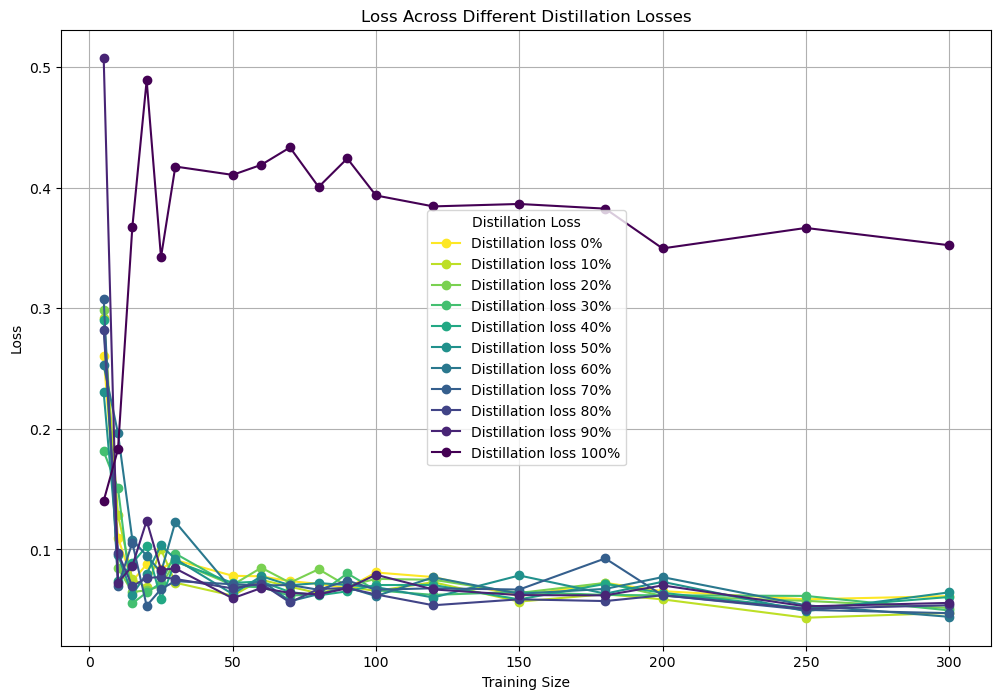

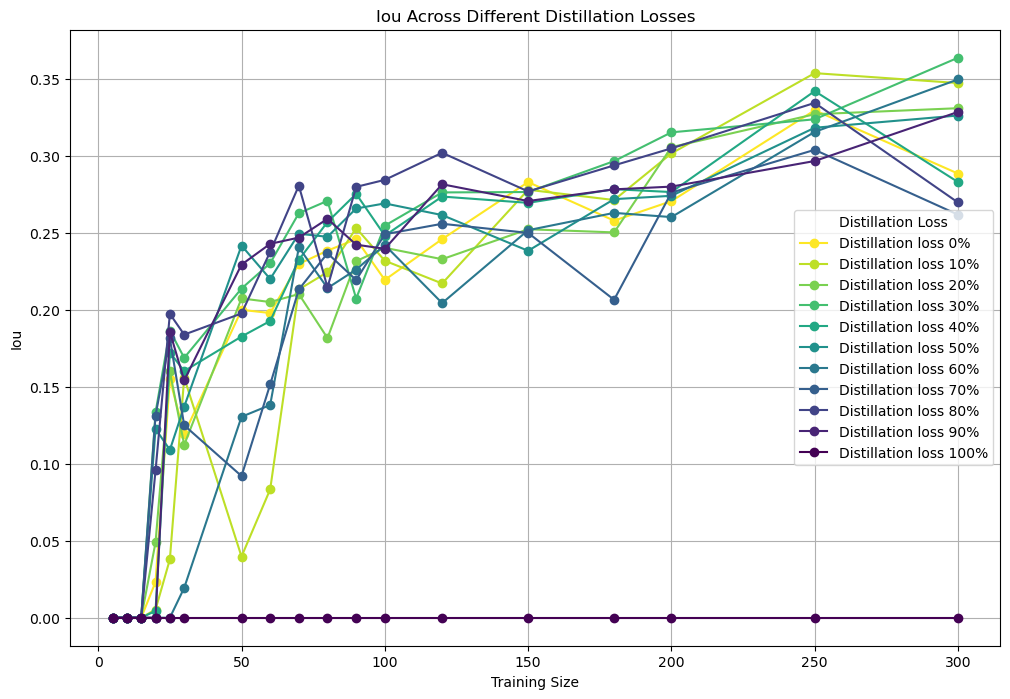

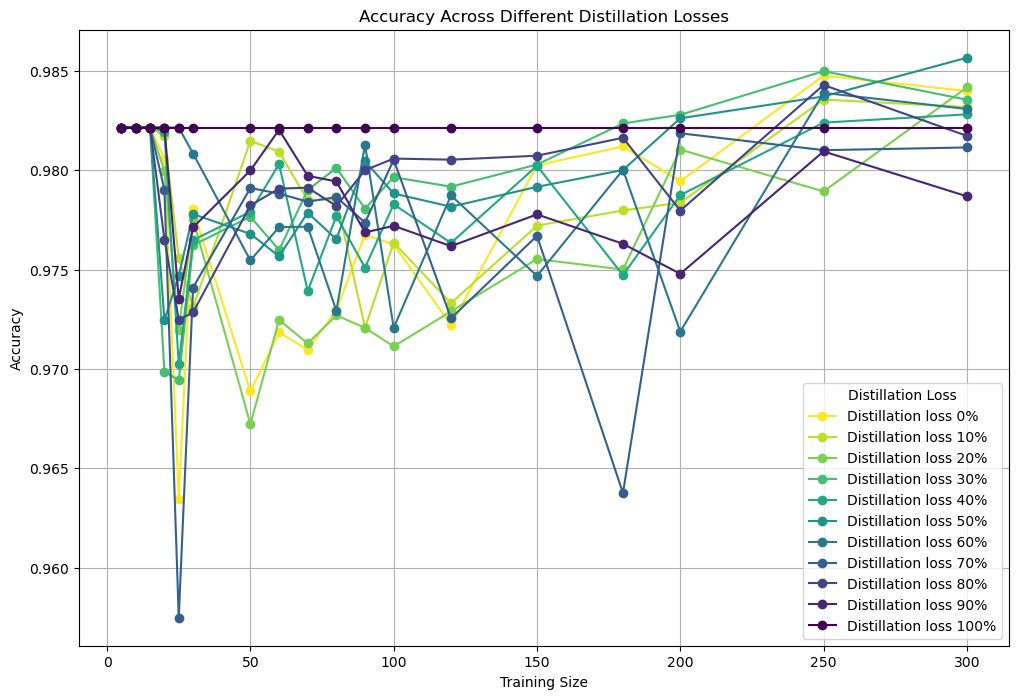

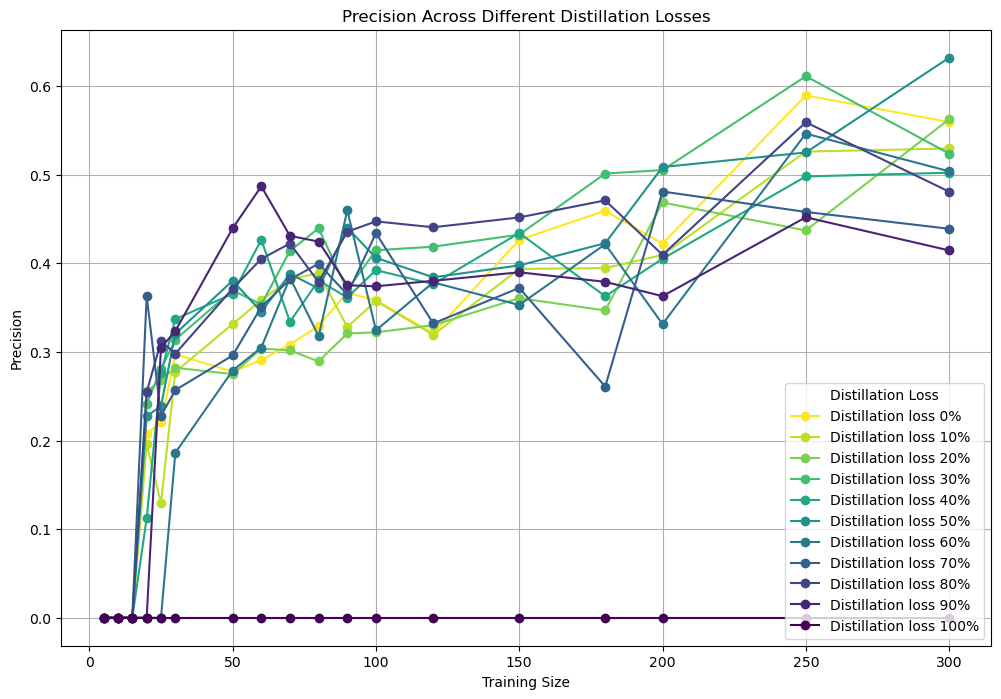

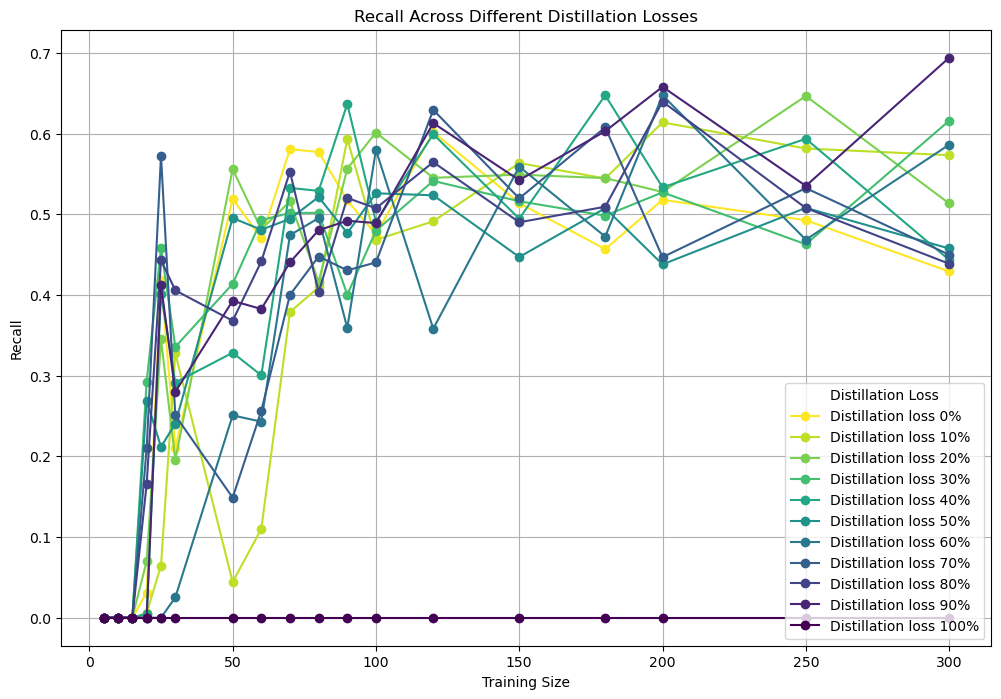

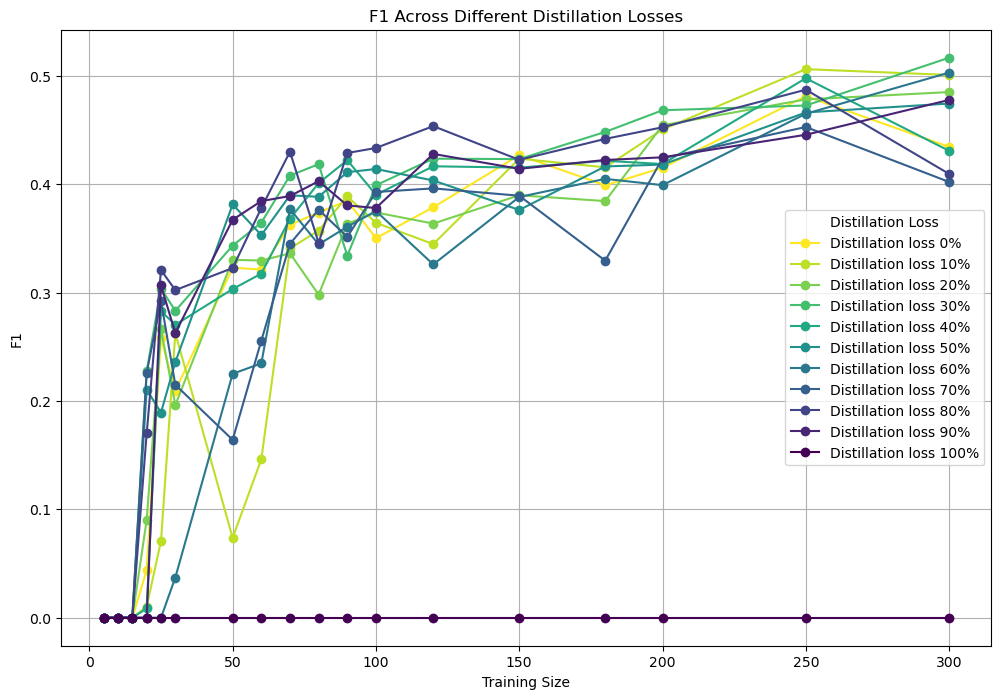

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pickle

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def load_metrics(filename):
    """ 從Pickle檔案讀取數據 """
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def plot_performance(all_avg_metrics, train_sizes, distillation_losses, metric_names):
    colors = plt.cm.viridis(np.linspace(1, 0, len(distillation_losses)))

    for metric in metric_names:
        plt.figure(figsize=(12, 8))
        for i, (metrics, dl) in enumerate(zip(all_avg_metrics, distillation_losses)):
            values = [m[metric] for m in metrics]
            plt.plot(train_sizes, values, marker='o', color=colors[i], label=f'Distillation loss {dl}%')

        plt.title(f'{metric.capitalize()} Across Different Distillation Losses')
        plt.xlabel('Training Size')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Distillation Loss')
        plt.grid(True)
        plt.show()

metric_names = ['loss', 'iou', 'accuracy', 'precision', 'recall', 'f1']
train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
distillation_losses = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# all_avg_metrics, all_std_metrics = test_model(model_segformer, test_loader, weight_dir)

# 讀取之前儲存的 all_avg_metrics 和 all_std_metrics
saved_metric_dir =select_folder()
filename = 'test_metrics_data.pkl'
file_path = os.path.join(saved_metric_dir, filename)

all_avg_metrics = load_metrics(file_path)
print("Loaded data:", all_avg_metrics['avg_metrics'])

plot_performance(all_avg_metrics['avg_metrics'], train_sizes, distillation_losses, metric_names)


In [ ]:
metrics_keys = metric_test[0].keys()
train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]

for key in metrics_keys:
    plt.figure()
    metric_values = [metrics[key] for metrics in metric_test]
    plt.plot(train_sizes, metric_values, marker='o')
    plt.title(f'{key} vs Dataset Size')
    plt.xlabel('Dataset Size')
    plt.ylabel(key)
    plt.grid(True)
    plt.show()